In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

--2022-12-19 07:24:03--  https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-12-19 07:24:03 ERROR 404: Not Found.



In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 23.6 MB/s 


In [ ]:
import tensorflow_hub as hub
import tokenization1
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
df=pd.read_csv("/content/FINAL_DATA.csv")

In [ ]:
df.head()

,text,label,cleanData
0,"At about 8:00 pm on 10.09.1996, the\r\ndecease...",murder,pm deceased along employee kamlesh pw left del...
1,"between 26th and 27th November, 2000 when all ...",murder,november family member sleeping appellant accu...
2,"The case of the prosecution in brief is that, ...",murder,case prosecution brief accused resident villag...
3,I submit that my wife burnt to death this\r\ne...,murder,submit wife burnt death evening p shop brother...
4,They entered the house and saw\r\nParamjit Sin...,murder,entered house saw paramjit singh floor appella...


In [ ]:
df.label.describe()

count        348
unique         3
top       murder
freq         149
Name: label, dtype: object

In [ ]:
df['target']=df.label.map({"murder":0,"kidnapping":1,"sexual offense":2})

In [ ]:
df.target.astype(int)

0      0
1      0
2      0
3      0
4      0
      ..
343    0
344    0
345    0
346    0
347    0
Name: target, Length: 348, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.cleanData,df.target, test_size = 0.2, stratify = df.target,random_state = 42)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization1.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=171):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=171):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
import keras
max_len = 171
train_input = bert_encode(X_train, tokenizer, max_len=max_len)
test_input = bert_encode(X_test, tokenizer, max_len=max_len)
train_labels = y_train

In [ ]:
import tensorflow as tf
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 171)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 171)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 171)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 171, 768)]                'input_mask[0][0]',         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max',save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=8, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_data=(test_input,y_test),
    epochs=7,
    callbacks=[checkpoint, earlystopping],
    batch_size=30,verbose=1)

Epoch 1/7
10/10 [==============================] - ETA: 0s - loss: 0.9839 - accuracy: 0.5216
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to model.h5
10/10 [==============================] - 39s 2s/step - loss: 0.9839 - accuracy: 0.5216 - val_loss: 0.7578 - val_accuracy: 0.7143
Epoch 2/7
10/10 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.7266
Epoch 2: val_accuracy improved from 0.71429 to 0.80000, saving model to model.h5
10/10 [==============================] - 17s 2s/step - loss: 0.7333 - accuracy: 0.7266 - val_loss: 0.5759 - val_accuracy: 0.8000
Epoch 3/7
10/10 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.8094
Epoch 3: val_accuracy improved from 0.80000 to 0.87143, saving model to model.h5
10/10 [==============================] - 16s 2s/step - loss: 0.5913 - accuracy: 0.8094 - val_loss: 0.4299 - val_accuracy: 0.8714
Epoch 4/7
10/10 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8597
E

In [ ]:
model.evaluate(test_input,y_test) 

3/3 [==============================] - 1s 230ms/step - loss: 0.3026 - accuracy: 0.8857


[0.30263790488243103, 0.8857142925262451]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

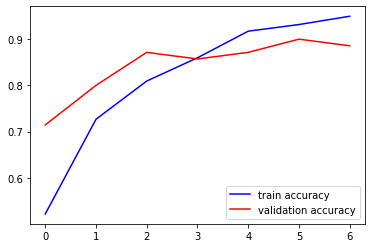

In [ ]:
plt.plot(train_history.history['accuracy'],c='b',label='train accuracy')
plt.plot(train_history.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

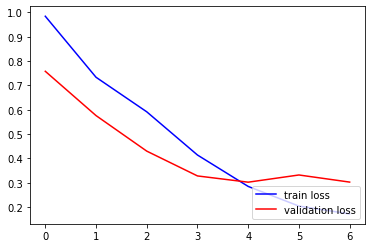

In [ ]:
plt.plot(train_history.history['loss'],c='b',label='train loss')
plt.plot(train_history.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
X_new=["carrying business taxi shimla december p gone hotel apsara cart road shimla inquire budhi singh pw manager hotel apsara regarding booking taxi passenger staying hotel budhi singh pw asked jai pal pw come time went together hotel basant celebrating new year took wine dinner together remained said hotel till clock thereafter budhi singh pw returned hotel apsara jai pal pw came towards cart road met romi kapoor pw pawan kumar pw deep chand rajnish alias rintu inquired booking room hotel earlier agreed upon jai pal pw went hotel apsara not find budhi singh pw therefore went upstairs hall hotel found accused manjeet singh along balraj surender kumar taking liquor jai pal pw inquired appellant accused manjeet singh manager hotel accused alleged retorted not chowkidar hotel know tell manager accusedmanjeet singh alleged started abusing jai pal pw proclaiming serving punjab police accused alleged started beating jai pal pw giving fist blow mouth jai pal pw ran outside met named romi kapoor pw deep chand pawan kumar pw rajnish narrated incident romi kapoor pw rajnish alias rintu pawan kumar pw went inside hall jai pal pw one roshan remained standing entrance hotel rajnish alias rintu inquired accused manjeet singh cause given beating jai pal pw accused alleged told companion balraj surender kumar tell rajnish friend cause beating jai pal pw balraj surender kumar alleged abetted instigated accused saying carbine ka kamal dekhao whereupon accused alleged fired shot carbine hit rajnish alias rintu romi kapoor pw jai pal pw pawan kumar pw rajnish alias rintu sustained two shot chest fell ground accused balraj alleged run away gun shot jai pal pw lifted rajnish alias rintu carried g c hospital shimla declared dead"]
new_input = bert_encode(X_new, tokenizer, max_len=max_len)

In [ ]:
pred=model.predict(new_input)
pred

1/1 [==============================] - 1s 544ms/step


array([[0.94462115, 0.04657032, 0.00880852]], dtype=float32)

In [ ]:
labels = ['murder','kidnapping','sexual offense']
print(pred, labels[np.argmax(pred)])

[[0.94462115 0.04657032 0.00880852]] murder


In [ ]:
from sklearn.metrics import classification_report

y_pred=model.predict(test_input)
predicted = np.argmax(y_pred, axis=1)
report = classification_report(y_test, predicted)
print(report)

3/3 [==============================] - 1s 368ms/step
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.80      0.80      0.80        10
           2       0.85      0.97      0.91        30

    accuracy                           0.89        70
   macro avg       0.87      0.87      0.87        70
weighted avg       0.89      0.89      0.89        70



In [ ]:
# model1 = keras.models.load_model('model.h5')

# X_new=["carrying business taxi shimla december p gone hotel apsara cart road shimla inquire budhi singh pw manager hotel apsara regarding booking taxi passenger staying hotel budhi singh pw asked jai pal pw come time went together hotel basant celebrating new year took wine dinner together remained said hotel till clock thereafter budhi singh pw returned hotel apsara jai pal pw came towards cart road met romi kapoor pw pawan kumar pw deep chand rajnish alias rintu inquired booking room hotel earlier agreed upon jai pal pw went hotel apsara not find budhi singh pw therefore went upstairs hall hotel found accused manjeet singh along balraj surender kumar taking liquor jai pal pw inquired appellant accused manjeet singh manager hotel accused alleged retorted not chowkidar hotel know tell manager accusedmanjeet singh alleged started abusing jai pal pw proclaiming serving punjab police accused alleged started beating jai pal pw giving fist blow mouth jai pal pw ran outside met named romi kapoor pw deep chand pawan kumar pw rajnish narrated incident romi kapoor pw rajnish alias rintu pawan kumar pw went inside hall jai pal pw one roshan remained standing entrance hotel rajnish alias rintu inquired accused manjeet singh cause given beating jai pal pw accused alleged told companion balraj surender kumar tell rajnish friend cause beating jai pal pw balraj surender kumar alleged abetted instigated accused saying carbine ka kamal dekhao whereupon accused alleged fired shot carbine hit rajnish alias rintu romi kapoor pw jai pal pw pawan kumar pw rajnish alias rintu sustained two shot chest fell ground accused balraj alleged run away gun shot jai pal pw lifted rajnish alias rintu carried g c hospital shimla declared dead"]
# new_input = bert_encode(X_new, tokenizer, max_len=max_len)

# # p = model.predict("carrying business taxi shimla december p gone hotel apsara cart road shimla inquire budhi singh pw manager hotel apsara regarding booking taxi passenger staying hotel budhi singh pw asked jai pal pw come time went together hotel basant celebrating new year took wine dinner together remained said hotel till clock thereafter budhi singh pw returned hotel apsara jai pal pw came towards cart road met romi kapoor pw pawan kumar pw deep chand rajnish alias rintu inquired booking room hotel earlier agreed upon jai pal pw went hotel apsara not find budhi singh pw therefore went upstairs hall hotel found accused manjeet singh along balraj surender kumar taking liquor jai pal pw inquired appellant accused manjeet singh manager hotel accused alleged retorted not chowkidar hotel know tell manager accusedmanjeet singh alleged started abusing jai pal pw proclaiming serving punjab police accused alleged started beating jai pal pw giving fist blow mouth jai pal pw ran outside met named romi kapoor pw deep chand pawan kumar pw rajnish narrated incident romi kapoor pw rajnish alias rintu pawan kumar pw went inside hall jai pal pw one roshan remained standing entrance hotel rajnish alias rintu inquired accused manjeet singh cause given beating jai pal pw accused alleged told companion balraj surender kumar tell rajnish friend cause beating jai pal pw balraj surender kumar alleged abetted instigated accused saying carbine ka kamal dekhao whereupon accused alleged fired shot carbine hit rajnish alias rintu romi kapoor pw jai pal pw pawan kumar pw rajnish alias rintu sustained two shot chest fell ground accused balraj alleged run away gun shot jai pal pw lifted rajnish alias rintu carried g c hospital shimla declared dead")

# # p = model1.predict(new_input)

# # print(p)